In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scvi
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import cell2location

from matplotlib import rcParams
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [14]:
outdir = "./lung_data/"
cancer = "Lung"
results_folder = outdir+cancer+'_analysis'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## 读取单细胞文件

In [8]:
adata_ref = sc.read_loom(outdir+'NSCLC_EMTAB6149_expression.loom')
meta = pd.read_table(outdir+"NSCLC_EMTAB6149_CellMetainfo_table.tsv")

In [9]:
adata_ref

AnnData object with n_obs × n_vars = 40218 × 18922
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident'
    layers: 'counts'

In [10]:
def Build_ref(adata_ref,meta,sample_counts):
    adata_ref.obs['Celltype'] = meta['Celltype (major-lineage)'].values
    adata_ref.obs['Cluster'] = meta['Cluster'].values
    adata_ref.obs['UMAP_1'] = meta['UMAP_1'].values
    adata_ref.obs['UMAP_2'] = meta['UMAP_2'].values
    
    # feature过滤，去掉一些表达比例比较低或者表达量低的基因
    selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    adata_ref = adata_ref[:, selected].copy()
    unnormal = np.exp(adata_ref.to_df())-1
    unnormal = np.floor(unnormal)
    adata_ref.X = unnormal.values
    
    # 这里将raw设置成当前的数据，否则后面的sampling会出问题
    adata_ref.raw = adata_ref
    sc.pp.subsample(adata_ref, n_obs = sample_counts)
    return adata_ref

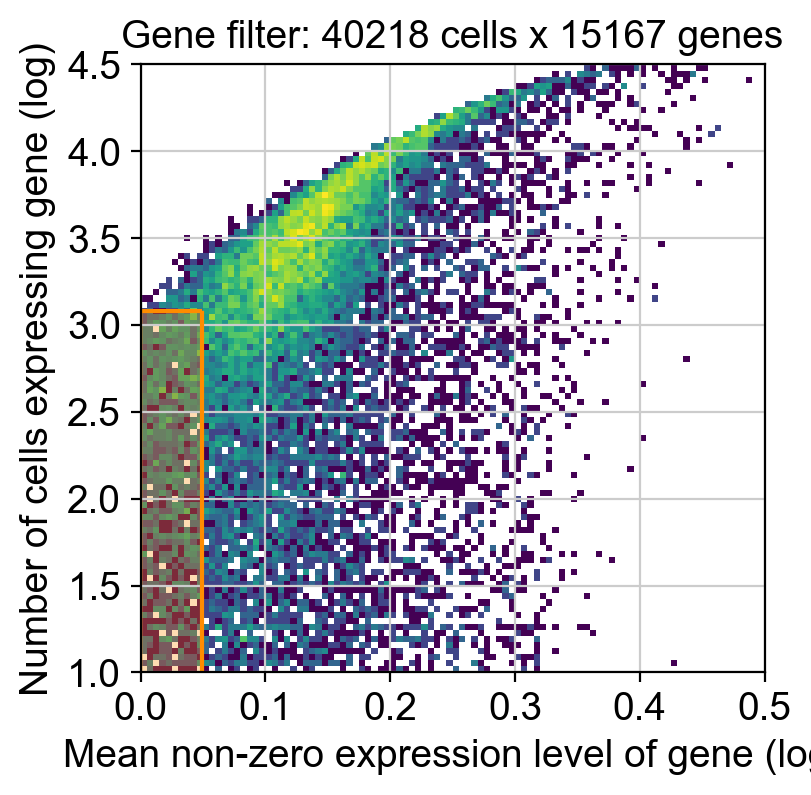

AnnData object with n_obs × n_vars = 38000 × 15167
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'Celltype', 'Cluster', 'UMAP_1', 'UMAP_2'
    var: 'n_cells', 'nonz_mean'
    layers: 'counts'

In [11]:
adata_ref = Build_ref(adata_ref,meta,sample_counts=38000)
adata_ref

## Estimation of reference cell type signatures (NB regression)

In [12]:
import torch
print(torch.cuda.is_available())

True


In [13]:
adata_ref.obs

nCount_RNA  nFeature_RNA  orig.ident     Celltype  \
CellID                                                                    
TCAGCTCTCTTAACCT_23  2210.181984           999           1    Malignant   
TTTCCTCTCGGCATCG_21  3940.223257          3453           1    Malignant   
TGAGAGGGTTACAGAA_19  1702.050221           628           1       CD8Tex   
CCAATCCCAAGGGTCA_17  1566.408628           549           1         CD8T   
TATCTCATCCGTCATC_22  2270.888110          1095           1   Mono/Macro   
...                          ...           ...         ...          ...   
ACCTTTATCGTCACGG_24  3012.563112          1831           1  Fibroblasts   
TGCTGCTGTTCTGAAC_24  1972.163145           814           1     CD4Tconv   
CCGTGGACACGGACAA_24  1740.657553           695           1         CD8T   
GTGCATAAGCCATCGC_23  2261.261569          1009           1    Malignant   
GCGGGTTGTAGCAAAT_21  2287.468548          1017           1    Malignant   

                     Cluster    UMAP_1     UMAP_2  
CellID                                             
TCAGCTCTCTTAACCT_23        7 -2.772317  -8.035740  
TTTCCTCTCGGCATCG_21        7 -3.693052  -6.762310  
TGAGAGGGTTACAGAA_19        0 -6.539788   6.754936  
CCAATCCCAAGGGTCA_17        5 -0.061629   6.253120  
TATCTCATCCGTCATC_22        9  8.154924   3.177837  
...                      ...       ...        ...  
ACCTTTATCGTCACGG_24       14 -3.806990 -13.762415  
TGCTGCTGTTCTGAAC_24        2 -2.580757   1.200884  
CCGTGGACACGGACAA_24        5 -2.479013   2.852230  
GTGCATAAGCCATCGC_23        7 -3.480560  -5.766656  
GCGGGTTGTAGCAAAT_21        7 -4.692922  -6.925193  

[38000 rows x 7 columns]

In [15]:
# cell2location会对reference fit Negative binomial distribution,
def SC_estimation(adata_ref,celltype):
    # 去除batch effects
    cell2location.models.RegressionModel.setup_anndata(adata= adata_ref,
    #                         batch_key='CellID',
                            labels_key=celltype
                                                      )
    mod = RegressionModel(adata_ref)
    mod.view_anndata_setup()
    
    mod.train(max_epochs=1000,accelerator='gpu')
    mod.plot_history()
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_ref = mod.export_posterior(
        adata_ref, 
        sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 
                       'use_gpu': True}
    )
    
    # Save model
    mod.save(f"{ref_run_name}", overwrite=True)
    
    # Save anndata object with results
    adata_file = f"{ref_run_name}/sc.h5ad"
    adata_ref.write(adata_file)
    return adata_ref,mod

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'Celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 38000 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  12   │
│          n_vars          │ 15167 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                    labels State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Celltype'] │  Alveolar   │          0          │
│                       │      B      │          1          │
│                       │  CD4Tconv   │          2          │
│                       │    CD8T     │          3          │
│                       │   CD8Tex    │          4          │
│                       │ Endothelial │          5          │
│                       │ Fibroblasts │          6          │
│                       │  Malignant  │          7          │
│                       │    Mast     │          8          │
│                       │ Mono/Macro  │          9          │
│                       │   Plasma    │         10          │
│                       │    Treg     │         11          │
└───────────────────────┴─────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|████████████████████████████████| 1000/1000 [39:34<00:00,  2.36s/it, v_num=1, elbo_train=2.32e+8]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Sampling global variables, sample: 100%|█████████████████████████████████████████████| 999/999 [00:11<00:00, 85.27it/s]


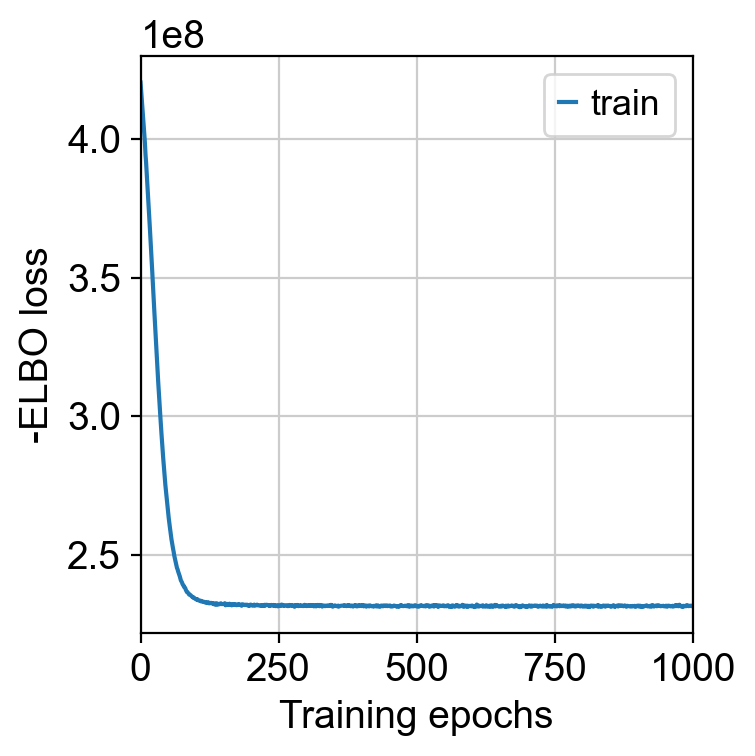

In [16]:
adata_ref,mod = SC_estimation(adata_ref,"Celltype")

In [10]:
# adata_ref = mod.export_posterior(
#     adata_ref, use_quantiles=True,
#     # choose quantiles
#     add_to_varm=["q05","q50", "q95", "q0001"],
#     sample_kwargs={'batch_size': 2500, 'use_gpu': False}
# )

In [17]:
adata_ref

AnnData object with n_obs × n_vars = 38000 × 15167
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'Celltype', 'Cluster', 'UMAP_1', 'UMAP_2', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    varm: 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'
    layers: 'counts'

In [18]:
adata_ref.uns['mod']['post_sample_means']['per_cluster_mu_fg'].shape

(12, 15167)

### Examine QC plots.

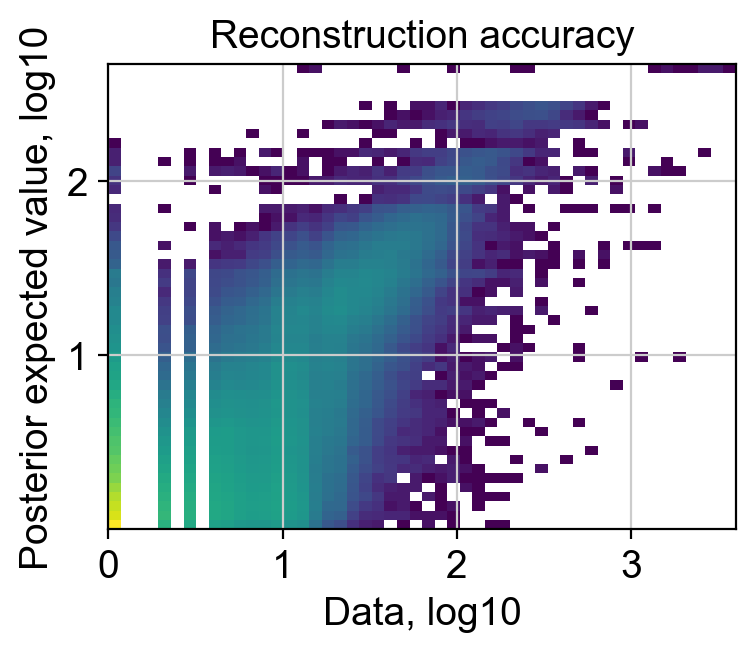

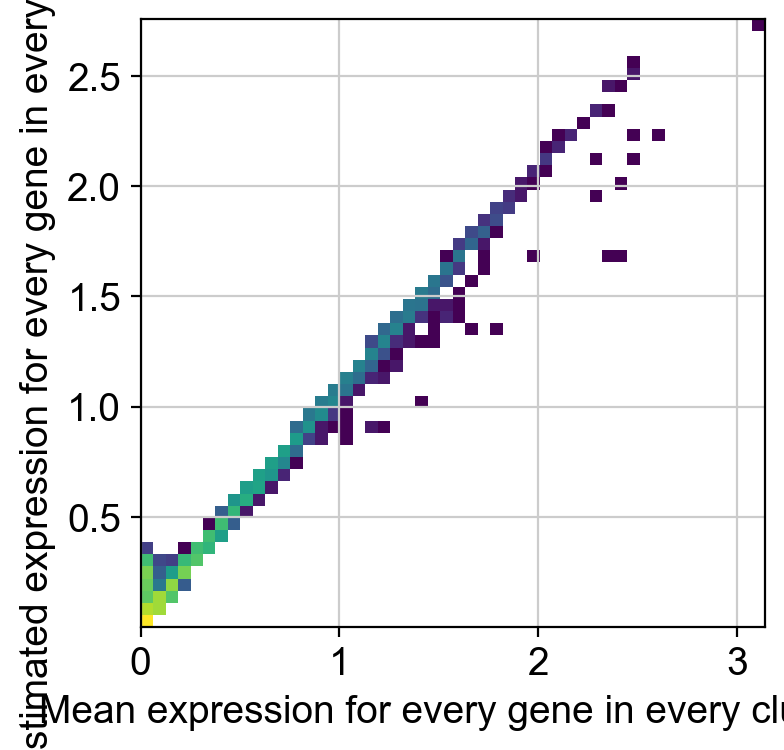

In [19]:
mod.plot_QC()
#重建准确性，以评估推断是否存在任何问题。这个2D直方图图应该沿着有噪声的对角线具有大多数观测值。

In [20]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver

Alveolar          B   CD4Tconv       CD8T     CD8Tex  \
Gene                                                                
AL669831.5   0.347219   0.283842   0.016571   0.222657   0.017260   
LINC00115    0.038871   0.040115   0.041107   0.074233   0.018899   
LINC02593    0.849456   0.757447   0.764350   0.420330   0.368534   
NOC2L        0.291509   0.716824   0.585480   0.580127   0.769840   
PLEKHN1      0.039948   0.010533   0.124621   0.041659   0.121611   
...               ...        ...        ...        ...        ...   
MT-ND4L      1.807092   2.025932   1.635595   1.691940   1.251117   
MT-ND4      48.816669  51.043182  39.543449  43.571724  34.090359   
MT-ND5       8.756396   6.905896   7.471066   8.766301   5.970407   
MT-ND6       0.916995   0.963322   0.872178   0.690314   0.737704   
MT-CYB      40.479031  40.907722  39.023991  38.552437  23.475767   

            Endothelial  Fibroblasts  Malignant       Mast  Mono/Macro  \
Gene                                                                     
AL669831.5     0.455768     0.398366   0.009714   0.728798    0.014259   
LINC00115      0.127021     0.061582   0.033912   0.209165    0.027938   
LINC02593      0.817350     0.818311   0.373095   0.963943    0.367833   
NOC2L          0.655765     0.641304   1.443850   0.352366    0.299855   
PLEKHN1        0.033971     0.052441   0.162413   0.056553    0.017598   
...                 ...          ...        ...        ...         ...   
MT-ND4L        1.799946     1.626373   1.280146   2.835016    2.054097   
MT-ND4        39.936840    40.050777  35.878292  44.008308   48.402962   
MT-ND5         7.565712     7.844558   6.004452   7.679960    9.119977   
MT-ND6         0.947127     0.484613   0.564773   0.819481    0.716180   
MT-CYB        33.470879    33.794575  25.652075  27.661596   31.518551   

               Plasma       Treg  
Gene                              
AL669831.5   0.567485   0.005964  
LINC00115    0.071028   0.026136  
LINC02593    0.778805   0.597103  
NOC2L        0.518243   0.691447  
PLEKHN1      0.176541   0.106175  
...               ...        ...  
MT-ND4L      1.123324   1.045810  
MT-ND4      30.066565  34.020798  
MT-ND5       5.698888   5.947888  
MT-ND6       0.716848   0.788796  
MT-CYB      21.789146  29.036631  

[15167 rows x 12 columns]

## Cell2location: spatial mapping 

In [21]:
adata_vis = sc.read_visium(
    path='./Spatial Cancer/Lung/',
    library_id=cancer,
    count_file='CytAssist_FFPE_Human_Lung_Squamous_Cell_Carcinoma_filtered_feature_bc_matrix.h5')

reading Spatial Cancer\Lung\CytAssist_FFPE_Human_Lung_Squamous_Cell_Carcinoma_filtered_feature_bc_matrix.h5
 (0:00:00)


In [22]:
def PreprocessST(adata_vis,inf_aver):
    adata_vis.obs_names_make_unique()
    adata_vis.var_names_make_unique()
    
    adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]  #标记样本名字

    # find shared genes and subset both anndata and reference signatures
    intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
    adata_vis = adata_vis[:, intersect].copy()
    inf_aver = inf_aver.loc[intersect, :].copy()
    return adata_vis,inf_aver

In [23]:
adata_vis,inf_aver = PreprocessST(adata_vis,inf_aver)
adata_vis

AnnData object with n_obs × n_vars = 3858 × 12517
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [24]:
def ST_estimation(adata_vis,inf_aver):
    # prepare anndata for cell2location model
    cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
    
    # create and train the model
    mod = cell2location.models.Cell2location(
        adata_vis, cell_state_df=inf_aver,
        # the expected average cell abundance: tissue-dependent
        # hyper-prior which can be estimated from paired histology:
        N_cells_per_location=30,
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection:
        detection_alpha=20
    )
    mod.view_anndata_setup()

    mod.train(max_epochs=30000,
              # train using full data (batch_size=None)
              batch_size=None,
              # use all data points in training because
              # we need to estimate cell abundance at all locations
              train_size=1,
    #           use_gpu=False,
              accelerator='gpu'
             )
    
    # plot ELBO loss history during training, removing first 100 epochs from the plot
    mod.plot_history(50)
    plt.legend(labels=['full data training'])
    
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_vis = mod.export_posterior(
        adata_vis, 
        sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
    )
    
    # Save model
    mod.save(f"{run_name}", overwrite=True)
    # mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
    
    # Save anndata object with results
    adata_file = f"{run_name}/sp.h5ad"
    adata_vis.write(adata_file)
    return adata_vis,mod

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3858  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12517 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    Lung    │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|██████████████████████████| 30000/30000 [1:21:29<00:00,  9.19it/s, v_num=1, elbo_train=4.81e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Sampling global variables, sample: 100%|█████████████████████████████████████████████| 999/999 [00:27<00:00, 36.76it/s]


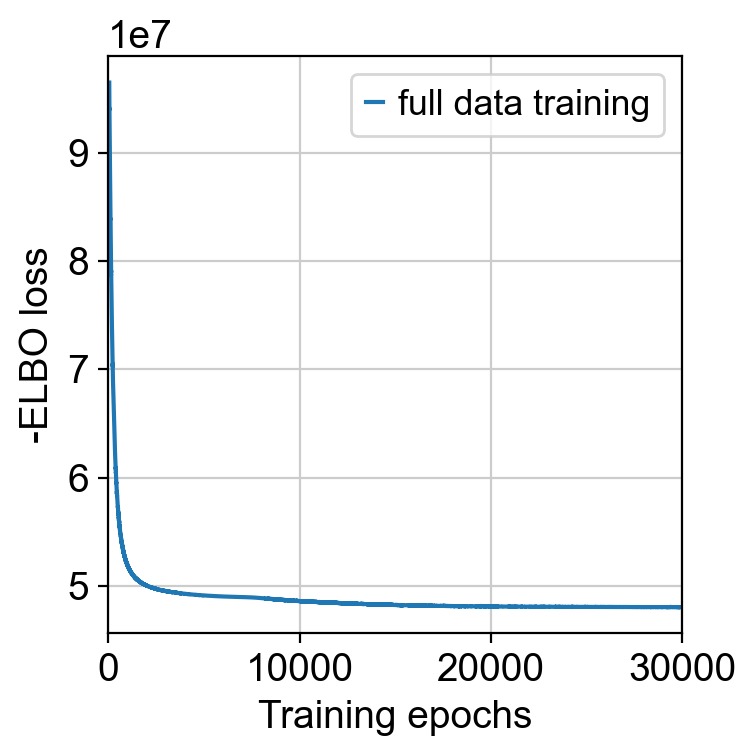

In [25]:
adata_vis,mod = ST_estimation(adata_vis,inf_aver)

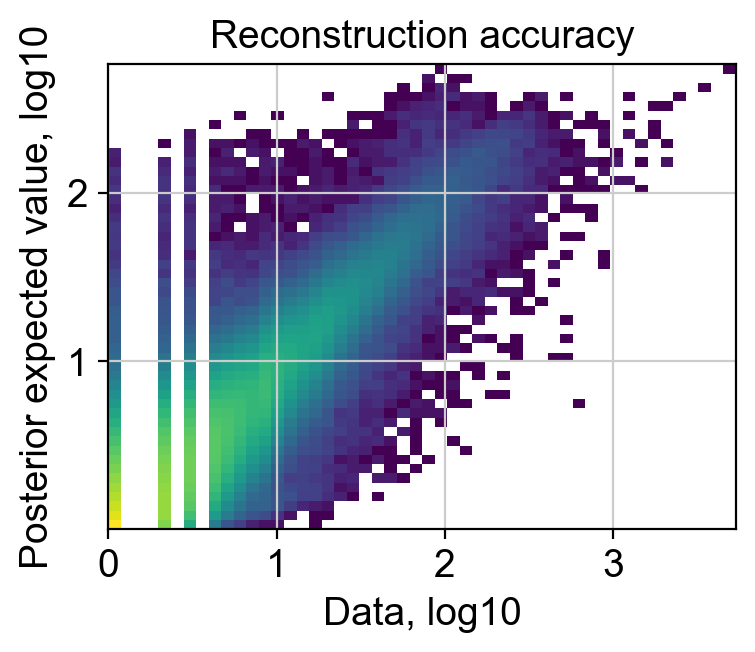

In [26]:
mod.plot_QC()

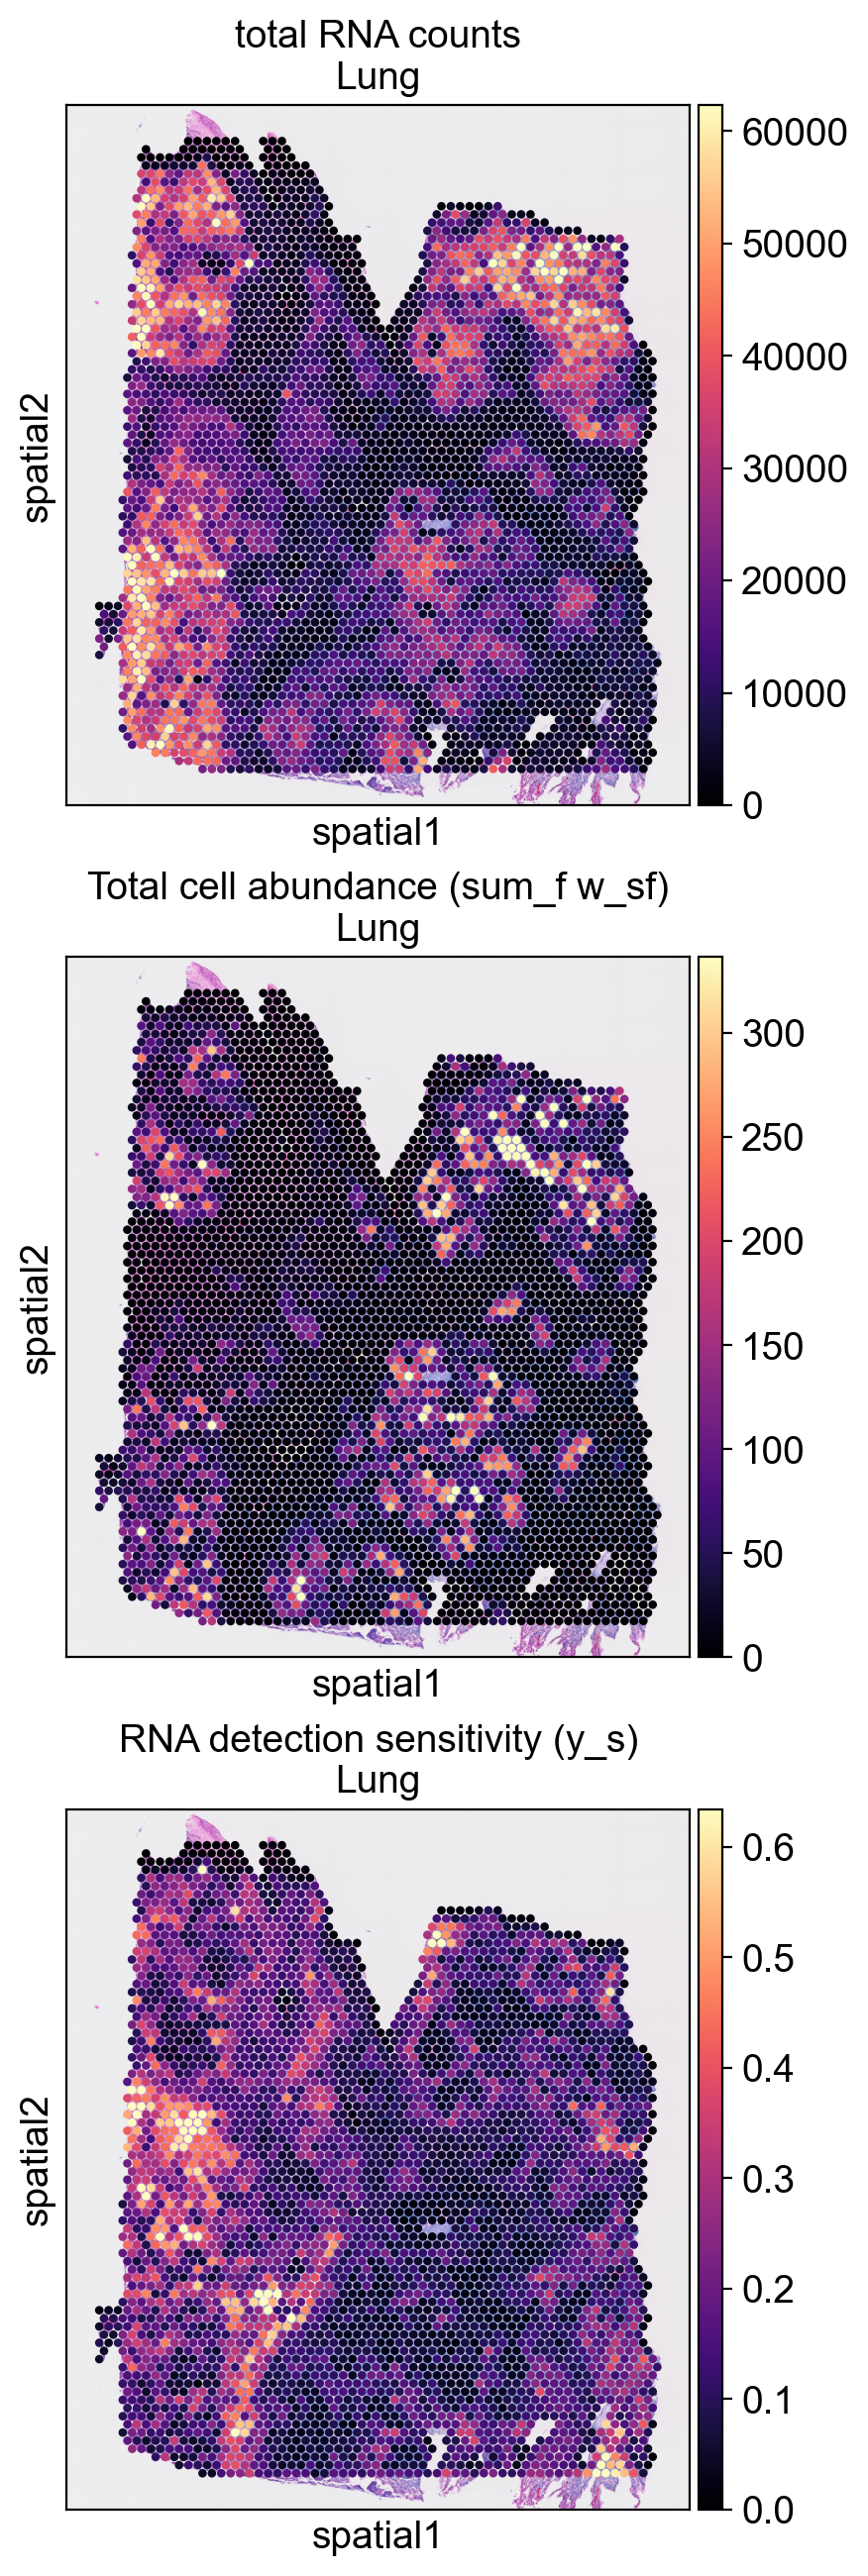

In [27]:
fig = mod.plot_spatial_QC_across_batches()

## Visualising cell abundance in spatial coordinates

In [28]:
def Visual_abundance(adata_vis,adata_ref):
    # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
    # to adata.obs with nice names for plotting
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
    
    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                         'figure.figsize': [4.5, 5]}):
    
        sc.pl.spatial(adata_vis, cmap='magma',
                      # show first 8 cell types
                      color=adata_ref.obs["Celltype"].unique().tolist(),
                      ncols=3, size=1.5,
                      img_key='hires',
                      # limit color scale at 99.2% quantile of cell abundance
                      vmin=0, vmax='p99.2'
                     )

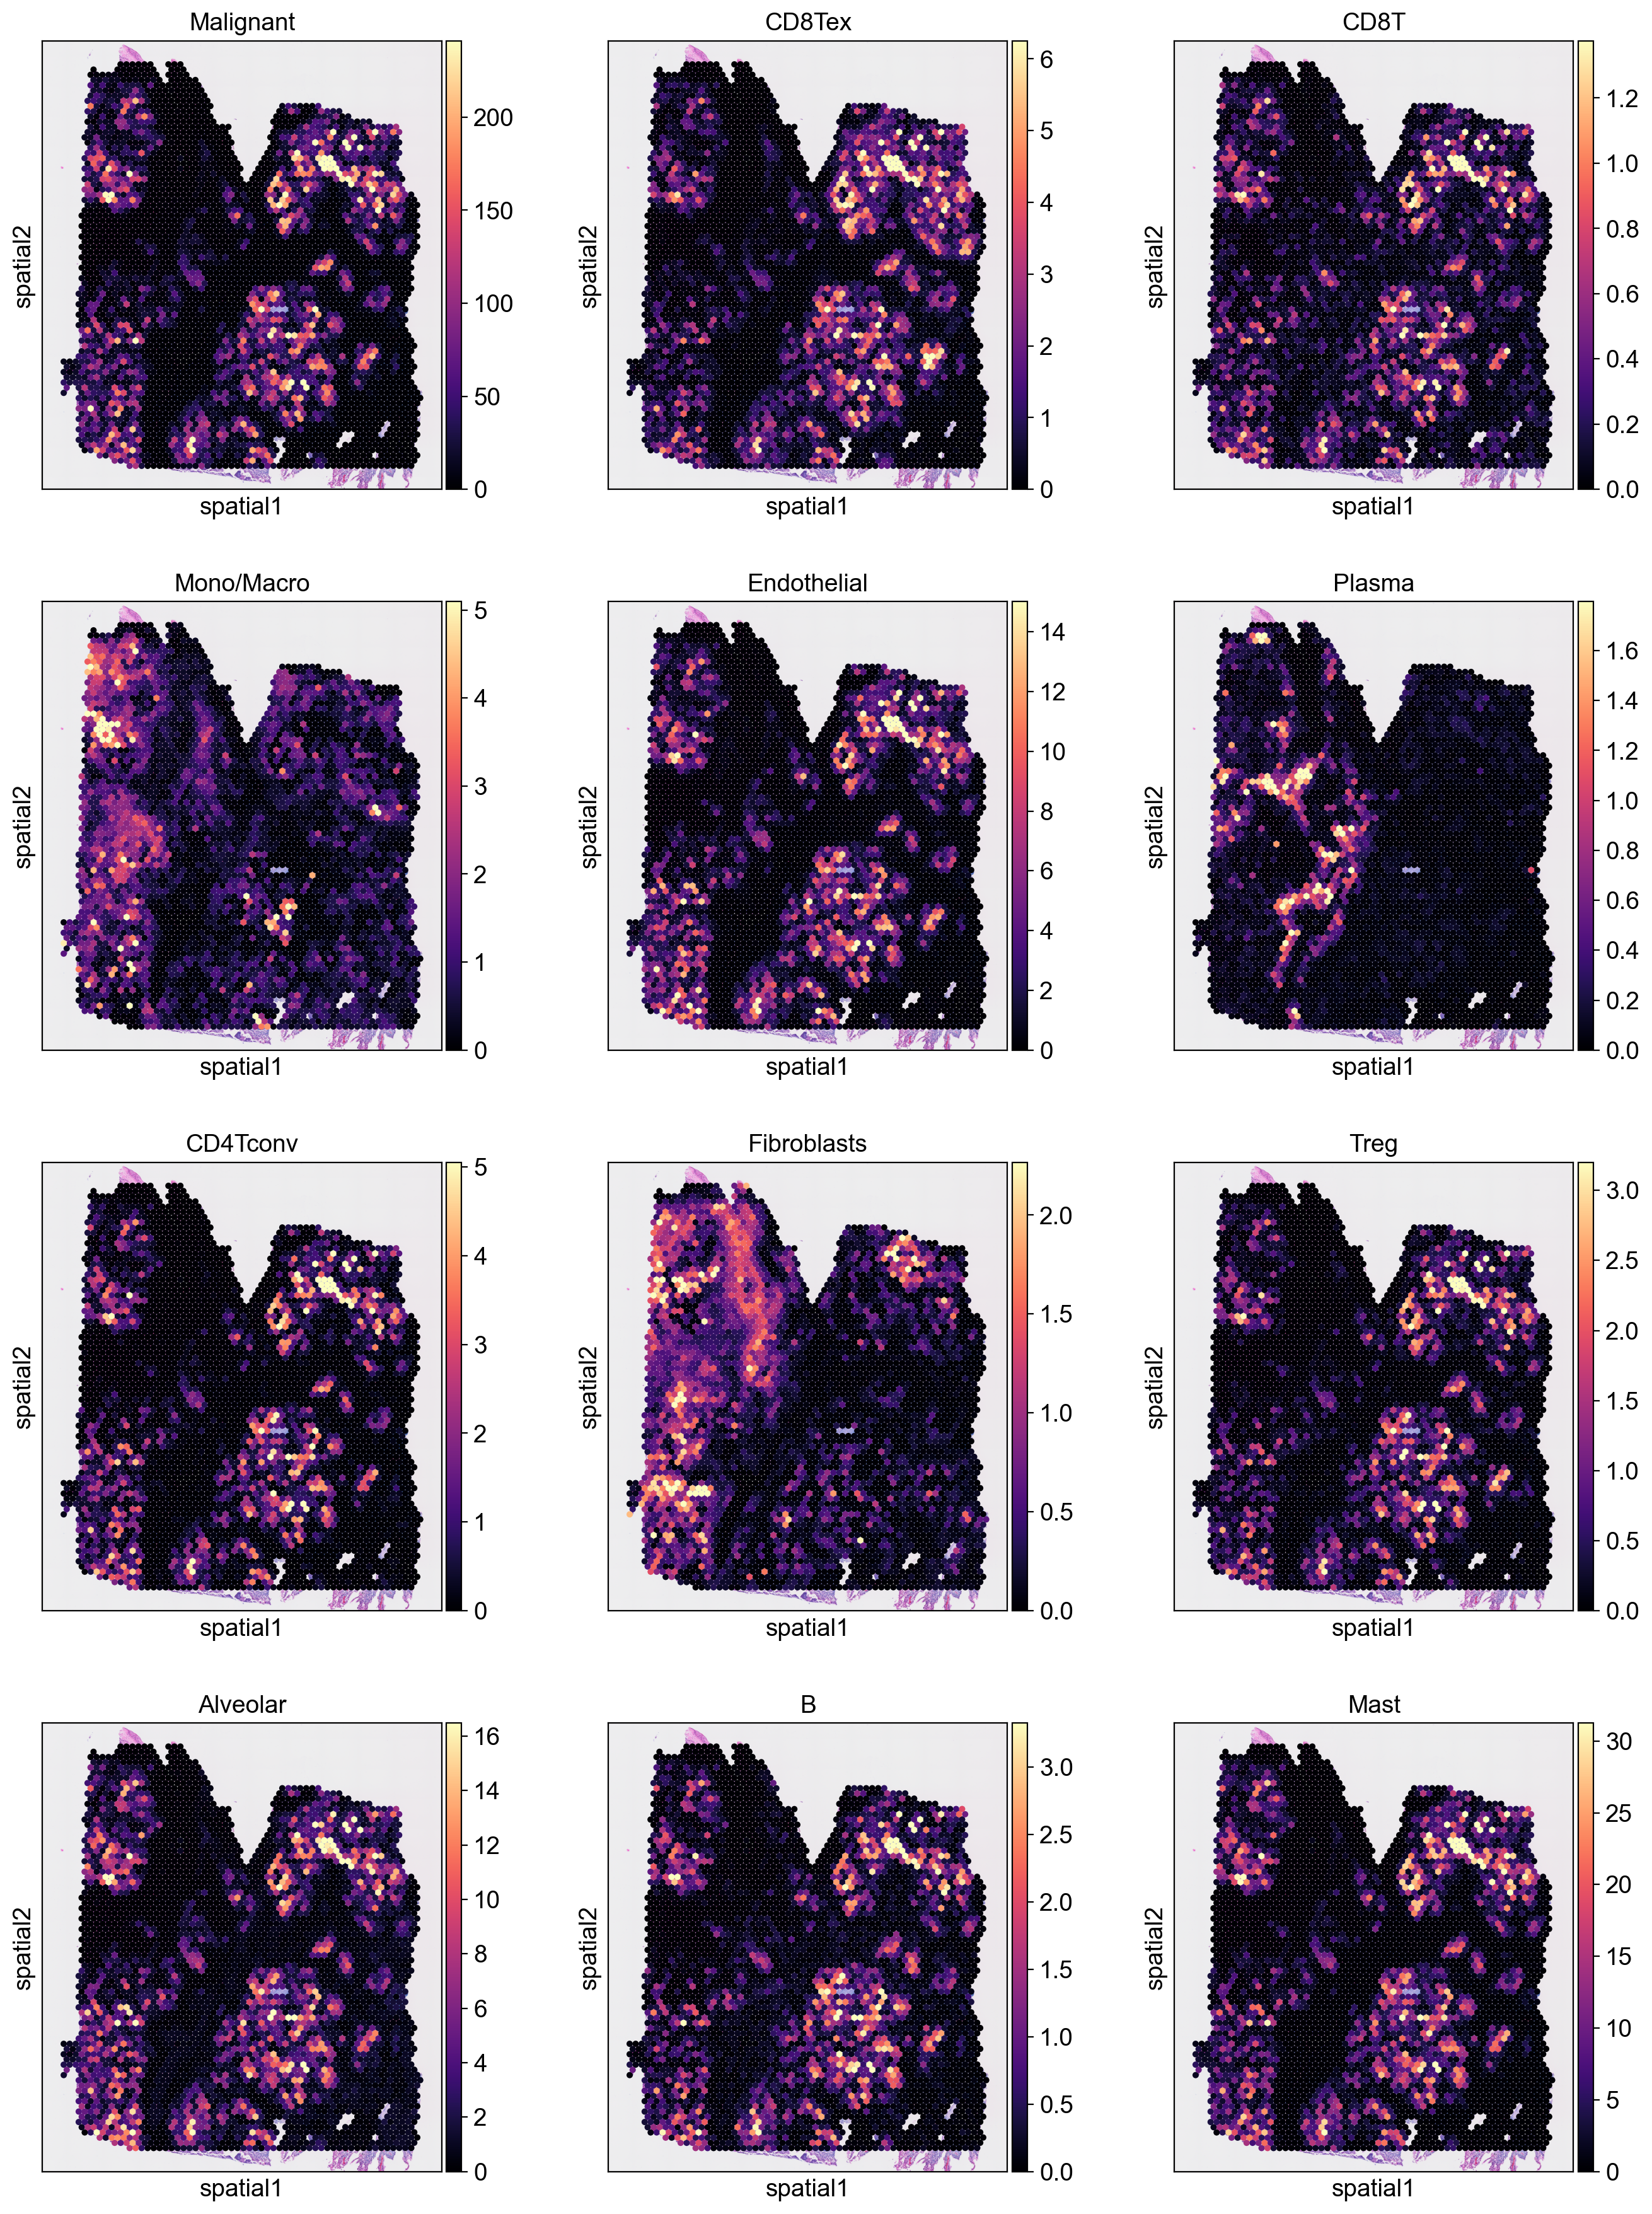

In [29]:
Visual_abundance(adata_vis,adata_ref)